In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from math import gamma

2024-12-11 01:38:29.327763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Problem 1. Linear Algebra

In [2]:
imgs_train, labels_train = mnist.load_data()[0]
imgs_train = imgs_train[:, 4:-4, 4:-4]
imgs_train = imgs_train.reshape((60000, -1))

In [3]:
def plot_mappings(X, M, labels, digits, colors):
  for i, color in zip(digits, colors):
    X_i = X[labels == i]
    X_i_mapped = X_i @ M
    plt.scatter(X_i_mapped[:, 0], X_i_mapped[:, 1], s=1, c=color, label=i)

  plt.legend()
  plt.show()

### Linear Discriminant Analysis

In [4]:
def scatter_matrices(X, labels, digits):
  mask = np.isin(labels, digits)
  n, d = X[mask].shape
  m = np.mean(X[mask], axis=0)

  S_w = np.zeros((d, d))
  S_b = np.zeros((d, d))
  for i in digits:
      X_i = X[labels == i, :]
      n_i = X_i.shape[0]
      m_i = np.mean(X_i, axis=0)

      S_b += n_i * np.outer(m_i - m, m_i - m)
      S_i = X_i - np.outer(np.ones(n_i), m_i)
      S_i = S_i.T @ S_i
      S_w += S_i
  return S_w, S_b

In [5]:
def lda(X, labels, digits, colors):
  S_w, S_b = scatter_matrices(X, labels, digits)

  L = np.linalg.cholesky(S_w)
  L_inv = np.linalg.inv(L)
  A = L_inv @ S_b @ L_inv.T

  evals, evecs = np.linalg.eigh(A)
  y = evecs[:, -2:]
  W = L_inv.T @ y
  plot_mappings(X, W, labels, digits, colors)

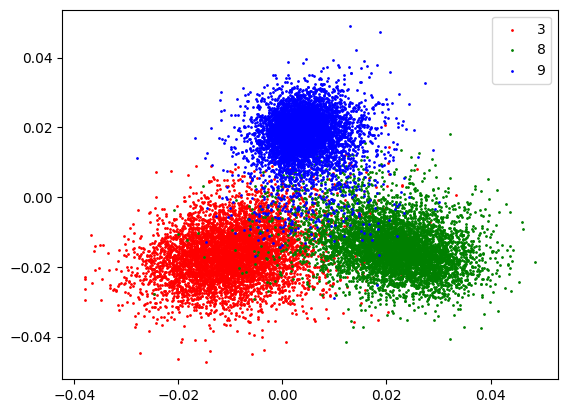

In [6]:
lda(imgs_train, labels_train, [3, 8, 9], ['r', 'g', 'b'])

### Principal Component Analysis

In [7]:
def pca(X, labels, digits, colors):
  mask = np.isin(labels, digits)
  X_digits = X[mask]
  n = X_digits.shape[0]
  m = np.mean(X_digits, axis=0)

  U, S, V_trans = np.linalg.svd(X_digits - np.outer(np.ones(n), m), full_matrices=False)
  V = np.transpose(V_trans)
  plot_mappings(X, V[:, :2], labels, digits, colors)

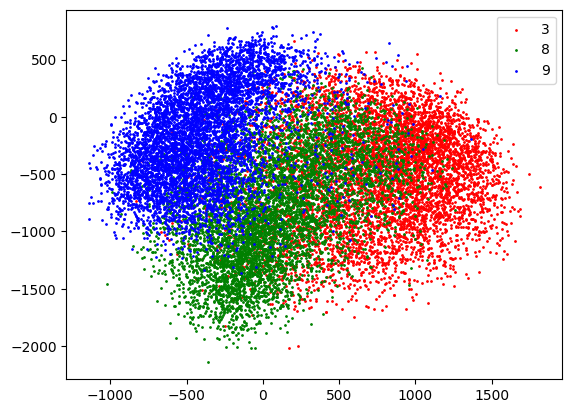

In [8]:
pca(imgs_train, labels_train, [3, 8, 9], ['r', 'g', 'b'])

# Problem 2. Optimization

In [9]:
Rhoop = 3 # the radius of the hoop
r0 = 1 # the equilibrial length of the springs
kappa = 1 # the spring constant
Nnodes = 21

A = np.zeros((Nnodes, Nnodes), dtype=int) # spring adjacency matrix
# vertical springs
for k in range(3):
    A[k, k + 4] = 1
for k in range(4, 7):
    A[k, k + 5] = 1
for k in range(9, 12):
    A[k, k + 5] = 1
for k in range(14, 17):
    A[k, k + 4] = 1
# horizontal springs
for k in range(3, 7):
    A[k, k + 1] = 1
for k in range(8, 12):
    A[k, k + 1] = 1
for k in range(13, 17):
    A[k, k + 1] = 1
# symmetrize
Asymm = A + np.transpose(A)

ind_hoop = [0, 3, 8, 13, 18, 19, 20, 17, 12, 7, 2, 1]
ind_free = [4, 5, 6, 9, 10, 11, 14, 15, 16]
springs = np.array(np.nonzero(A))

Nhoop = np.size(ind_hoop)
Nfree = np.size(ind_free)
Nsprings = np.size(springs, axis=1)

In [10]:
# Initial angles for the nodes are uniformly distributed around the range of 2 * pi
# starting from theta0 and going counterclockwise
theta0 = 2 * np.pi / 3
theta = theta0 + np.linspace(0, 2 * np.pi, Nhoop + 1)
theta = np.delete(theta, -1)

# Initial positions
pos = np.zeros((Nnodes, 2))
pos[ind_hoop, 0] = Rhoop * np.cos(theta)
pos[ind_hoop, 1] = Rhoop * np.sin(theta)
pos[ind_free, 0] = np.array([-1., 0., 1., -1., 0., 1., -1., 0., 1.])
pos[ind_free, 1] = np.array([1., 1., 1., 0., 0., 0., -1., -1., -1.])

# Initialize the vector of parameters to be optimized
vec = np.concatenate((theta, pos[ind_free, 0], pos[ind_free, 1]))

In [11]:
# plots the spring system stretched on the hoop
def draw_spring_system(pos, springs, R, ind_hoop, ind_free):
    # draw the hoop
    t = np.linspace(0, 2 * np.pi, 200)
    plt.plot(R * np.cos(t), R * np.sin(t), linewidth=5, c='r')

    # plot springs
    Nsprings = np.size(springs, axis=1)
    for k in range(Nsprings):
        j0 = springs[0, k]
        j1 = springs[1, k]
        plt.plot([pos[j0, 0], pos[j1, 0]], [pos[j0, 1], pos[j1, 1]], c='k', linewidth=3)

    # plot nodes
    plt.scatter(pos[ind_hoop, 0], pos[ind_hoop, 1], s=300, c='crimson')
    plt.scatter(pos[ind_free, 0], pos[ind_free, 1], s=300, c='k')
    plt.axis('equal')
    plt.show()

In [12]:
# computes the gradient of the energy function
def compute_gradient(theta, pos, Asymm, r0, kappa, R, ind_hoop, ind_free):
    Nhoop = np.size(ind_hoop)
    g_hoop = np.zeros((Nhoop,)) # gradient with respect to the angles of the hoop nodes
    Nfree = np.size(ind_free)
    g_free = np.zeros((Nfree, 2)) # gradient with respect to the x- and y-components of the free nodes
    for k in range(Nhoop):
        ind = np.squeeze(np.nonzero(Asymm[ind_hoop[k], :])) # index of the node adjacent to the kth node on the hoop
        rvec = pos[ind_hoop[k], :] - pos[ind, :] # the vector from that adjacent node to the kth node on the hoop
        rvec_length = np.linalg.norm(rvec) # the length of this vector
        g_hoop[k] = (rvec_length - r0)*R*kappa*(rvec[0]*(-np.sin(theta[k])) + rvec[1]*np.cos(theta[k]))/rvec_length
    for k in range(Nfree):
        ind = np.squeeze(np.array(np.nonzero(Asymm[ind_free[k], :]))) # indices of the nodes adjacent to the kth free node
        Nneib = np.size(ind)
        for j in range(Nneib):
            rvec = pos[ind_free[k], :] - pos[ind[j], :] # the vector from the jth adjacent node to the kth free node
            rvec_length = np.linalg.norm(rvec) # the length of this vector
            g_free[k, :] = g_free[k, :] + (rvec_length - r0) * R * kappa * rvec / rvec_length
    # return a single 1D vector
    return np.concatenate((g_hoop, g_free[:,0], g_free[:,1]))

# computes the energy function
def Energy(theta, pos, springs, r0, kappa):
    Nsprings = np.size(springs, axis=1)
    E = 0.
    for k in range(Nsprings):
        j0 = springs[0, k]
        j1 = springs[1, k]
        rvec = pos[j0, :] - pos[j1, :]
        rvec_length = np.linalg.norm(rvec)
        E = E + kappa * (rvec_length - r0)**2
    E = E * 0.5
    return E

In [13]:
def vec_to_pos(vec):
    theta = vec[:Nhoop]
    pos[ind_hoop, 0] = Rhoop * np.cos(theta)
    pos[ind_hoop, 1] = Rhoop * np.sin(theta)

    pos[ind_free, 0] = vec[Nhoop : Nnodes]
    pos[ind_free, 1] = vec[Nnodes:]
    return theta, pos

# evaluates the energy gradient given the vector of parameters as input
def gradient(vec):
    theta, pos = vec_to_pos(vec)
    return compute_gradient(theta, pos, Asymm, r0, kappa, Rhoop, ind_hoop, ind_free)

# evaluates the energy function given the vector of parameters as input
def func(vec):
    theta, pos = vec_to_pos(vec)
    return Energy(theta, pos, springs, r0, kappa)

In [14]:
def plot_convergence(x, loss, norm_grad_loss):
  # Print resulting energy and norm of the gradient
  print(f'Final Energy: {loss[-1]}')
  print(f'Final Energy Gradient Norm: {norm_grad_loss[-1]}')

  # Plot spring energy and the norm of its gradient versus iteration number
  fig, (ax1, ax2) = plt.subplots(2, 1)

  ax1.plot(loss)
  ax1.set_xlabel('$k$')
  ax1.set_ylabel('$f$')
  ax1.set_yscale('log')

  ax2.plot(norm_grad_loss)
  ax2.set_xlabel('$k$')
  ax2.set_ylabel('$||\\nabla f||$')
  ax2.set_yscale('log')

  plt.tight_layout()
  plt.show()

  # Plot view of the spring system stretched on the hoop
  theta, pos = vec_to_pos(x)
  draw_spring_system(pos, springs, Rhoop, ind_hoop, ind_free)

  # Print the positions of the nodes
  print(f'thetas:\n{theta}')
  print(f'xs:\n{pos[:, 0]}')
  print(f'ys:\n{pos[:, 1]}')

### Method 1: Nesterov

In [15]:
def nesterov(x, iters, alpha):
  v = np.zeros_like(x)
  losses = []
  grad_norms = []

  for k in range(iters):
    mu = 1 - 3 / (5 + k)
    v = mu * v - alpha * gradient(x + mu * v)
    x = x + v

    losses.append(func(x))
    grad_norms.append(np.linalg.norm(gradient(x)))
  return x, losses, grad_norms

Final Energy: 1.4924514116005914
Final Energy Gradient Norm: 7.808445365630911e-05


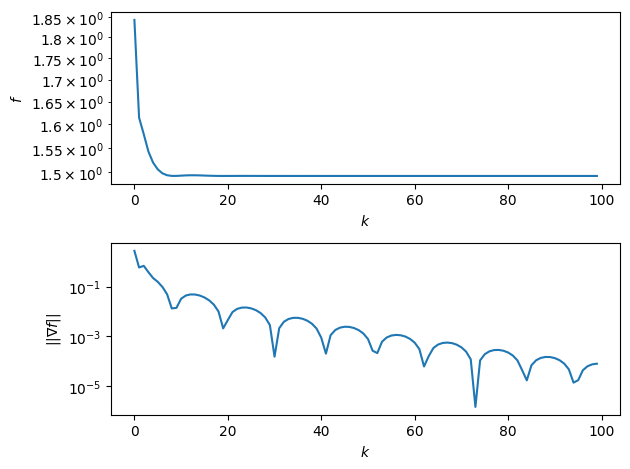

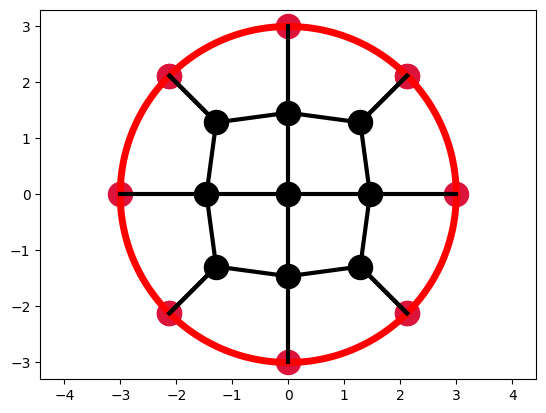

thetas:
[2.35622754 2.35616144 3.14159265 3.92702387 3.92695777 4.71238898
 5.49782019 5.49775409 6.28318531 7.06861652 7.06855042 7.85398163]
xs:
[-2.12139045e+00  9.18485099e-16  2.12139045e+00 -2.12125023e+00
 -1.28644040e+00  1.62098689e-16  1.28644040e+00  2.12125023e+00
 -3.00000000e+00 -1.46011554e+00  1.25953633e-16  1.46011554e+00
  3.00000000e+00 -2.12125023e+00 -1.28644040e+00 -3.65488647e-16
  1.28644040e+00  2.12125023e+00 -2.12139045e+00 -5.51091060e-16
  2.12139045e+00]
ys:
[ 2.12125023e+00  3.00000000e+00  2.12125023e+00  2.12139045e+00
  1.28644040e+00  1.46011554e+00  1.28644040e+00  2.12139045e+00
  3.67394040e-16  1.01852289e-16 -2.36305872e-16 -1.36066168e-16
 -7.34788079e-16 -2.12139045e+00 -1.28644040e+00 -1.46011554e+00
 -1.28644040e+00 -2.12139045e+00 -2.12125023e+00 -3.00000000e+00
 -2.12125023e+00]


In [16]:
plot_convergence(*nesterov(vec, 100, 1e-1))

### Method 2: Adam

In [17]:
# Adam as described in its original paper (https://arxiv.org/pdf/1412.6980)
def adam(theta, iters, alpha=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
  m = np.zeros_like(theta)
  v = np.zeros_like(theta)
  losses = []
  grad_norms = []

  for t in range(1, iters):
    g = gradient(theta)
    m = beta_1 * m + (1 - beta_1) * g
    v = beta_2 * v + (1 - beta_2) * g**2
    m_hat = m / (1 - beta_1**t)
    v_hat = v / (1 - beta_2**t)
    theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

    losses.append(func(theta))
    grad_norms.append(np.linalg.norm(gradient(theta)))
  return theta, losses, grad_norms

Final Energy: 1.4924514079576852
Final Energy Gradient Norm: 1.7808138590992066e-05


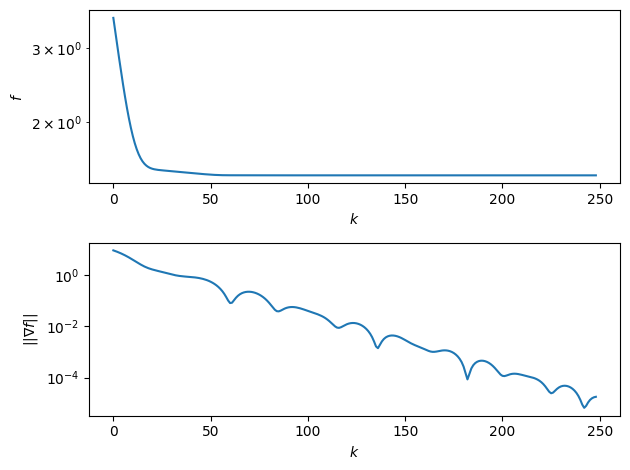

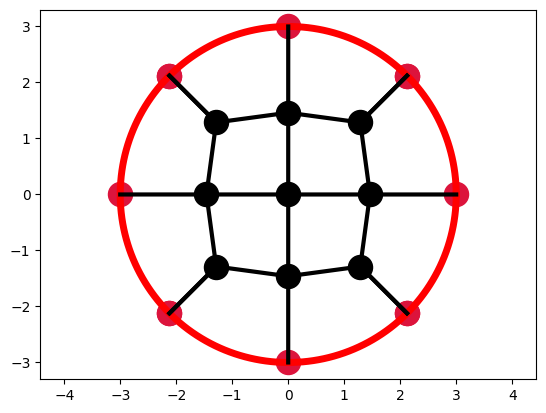

thetas:
[2.35613887 2.35613902 3.14153711 3.9269352  3.92693535 4.71233347
 5.49773152 5.49773167 6.28312977 7.06852784 7.06852799 7.85392606]
xs:
[-2.12120235e+00  1.66716406e-04  2.12143803e+00 -2.12120267e+00
 -1.28636835e+00  8.11018902e-05  1.28651128e+00  2.12143835e+00
 -3.00000000e+00 -1.46011474e+00 -1.98424844e-08  1.46011475e+00
  3.00000000e+00 -2.12143831e+00 -1.28651126e+00 -8.11101421e-05
  1.28636836e+00  2.12120267e+00 -2.12143799e+00 -1.66530267e-04
  2.12120235e+00]
ys:
[ 2.12143833e+00  3.00000000e+00  2.12120265e+00  2.12143801e+00
  1.28651127e+00  1.46011474e+00  1.28636835e+00  2.12120233e+00
  1.66619980e-04  8.11099653e-05  1.08360791e-08 -8.11210854e-05
 -1.66616323e-04 -2.12120237e+00 -1.28636836e+00 -1.46011475e+00
 -1.28651127e+00 -2.12143801e+00 -2.12120269e+00 -3.00000000e+00
 -2.12143833e+00]


In [18]:
plot_convergence(*adam(vec, 250, alpha=2e-2))

# Problem 3. Monte Carlo

In [19]:
# Using i.i.d. uniform samples from the d-dimensional unit cube
def vol_uniform_cube(n, d):
  x = np.random.uniform(-0.5, 0.5, (n, d))

  ind_ball = np.linalg.norm(x, axis=1) <= 1
  vol_cube = 1
  return vol_cube * np.mean(ind_ball)

In [20]:
# Using i.i.d. uniform samples from the d-dimensional unit ball
def vol_uniform_ball(n, d):
  x = np.random.normal(size=(n, d))
  x /= np.linalg.norm(x, axis=1, keepdims=True)
  r = np.random.uniform(0, 1, n) ** (1 / d)
  x *= r[:, np.newaxis]

  ind_cube = np.max(np.abs(x), axis=1) <= 0.5
  vol_ball = np.pi**(d / 2) / (d / 2 * gamma(d / 2))
  return vol_ball * np.mean(ind_cube)

In [21]:
n = 10**7
ds = [5, 10, 15, 20]

print('Method 1: Sequence in unit cube')
for d in ds:
  print(f'd={d}, Vol={vol_uniform_cube(n, d)}')

print('\nMethod 2: Sequence in unit ball')
for d in ds:
  print(f'd={d}, Vol={vol_uniform_ball(n, d)}')

Method 1: Sequence in unit cube
d=5, Vol=0.9995623
d=10, Vol=0.7627243
d=15, Vol=0.1973268
d=20, Vol=0.0182212

Method 2: Sequence in unit ball
d=5, Vol=0.9996003766680481
d=10, Vol=0.7625084835302737
d=15, Vol=0.19721937412316487
d=20, Vol=0.0182436502462078
